# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [3]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [4]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [5]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [24]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균
cols = ['Income', 'Total_Spending', 'Age']

for col in cols:
    print(f"---{col}---")
    print(f"평균: {df[col].mean():.4f}")
    print(f"중앙값: {df[col].median():.1f}")
    print(f"최빈값: {df[col].mode().values}")
    
    print(f"절사평균: {stats.trim_mean(df[col].dropna(), 0.05):.4f}")
    print()

---Income---
평균: 51952.6140
중앙값: 51381.5
최빈값: [51381.5]
절사평균: 51740.1534

---Total_Spending---
평균: 605.9866
중앙값: 396.5
최빈값: [46]
절사평균: 561.1197

---Age---
평균: 55.1020
중앙값: 54.0
최빈값: [48]
절사평균: 55.0750



In [23]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)

for col in cols:
    print(f"---{col}---")
    print(f"분산: {df[col].var(ddof=1):.4f}")
    
    print(f"표준편차: {df[col].std(ddof=1):.4f}")
    
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    print(f"IQR: {IQR}")

    print(f"CV: {(df[col].std() / df[col].mean()) * 100:.4f}")
    print()

---Income---
분산: 458450912.6926
표준편차: 21411.4669
IQR: 32773.25
CV: 41.2135

---Total_Spending---
분산: 362241.6660
표준편차: 601.8652
IQR: 976.5
CV: 99.3199

---Age---
분산: 136.9668
표준편차: 11.7033
IQR: 18.0
CV: 21.2393



### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

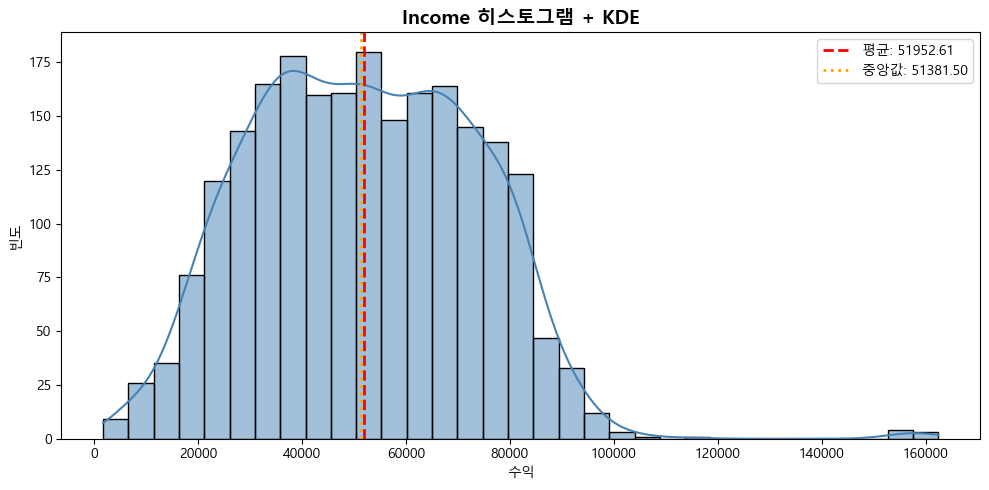

In [30]:
# TODO 1-2(a): Income 히스토그램 + KDE
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(data=df, x='Income', kde=True, color='steelblue', ax=ax)

income_mean=df['Income'].mean()
income_median=df['Income'].median()

ax.axvline(income_mean, color='red', linestyle='--', linewidth=2, label=f"평균: {income_mean:.2f}")
ax.axvline(income_median, color='orange', linestyle=':', linewidth=2, label=f'중앙값: {income_median:.2f}')

ax.set_title('Income 히스토그램 + KDE', fontsize=14, fontweight='bold')
ax.set_xlabel('수익')
ax.set_ylabel('빈도')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

하한선 : -1395.75
상한선 : 2510.25
이상치 개수 : 3


Text(0.5, 1.0, 'Total_Spending 박스플롯')

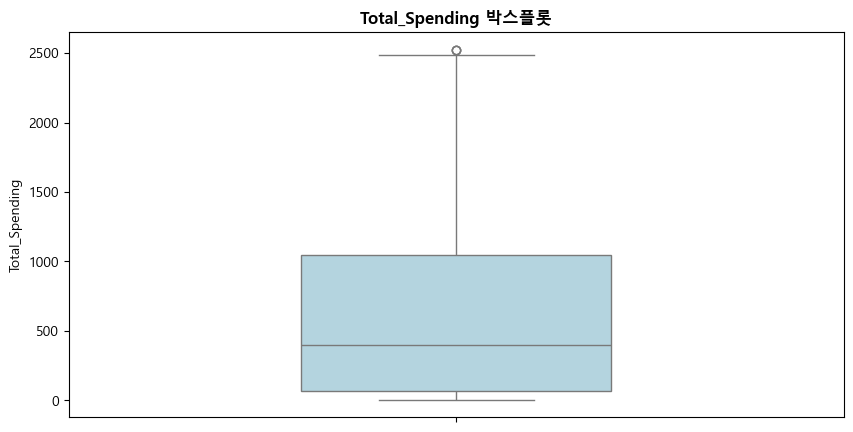

In [ ]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치
Q1 = df['Total_Spending'].quantile(0.25)
Q3 = df['Total_Spending'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Total_Spending'] < lower_bound) | (df['Total_Spending'] > upper_bound)]

print(f"하한선 : {lower_bound}")
print(f"상한선 : {upper_bound}")
print(f"이상치 개수 : {len(outliers)}")


fig, axes = plt.subplots(figsize=(10, 5))

sns.boxplot(y=df['Total_Spending'], ax=axes, color='lightblue', width=0.4)
axes.set_ylabel('Total_Spending')
axes.set_title("Total_Spending 박스플롯", fontweight='bold')

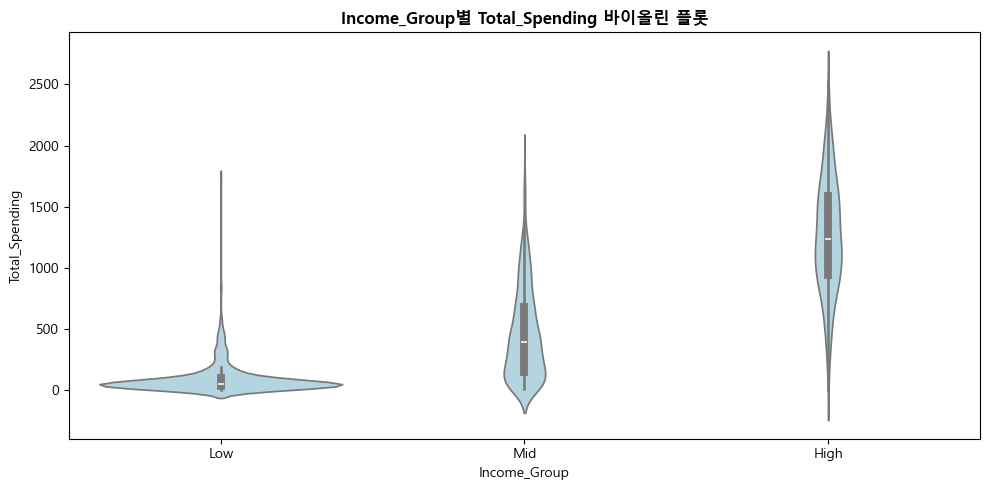

In [41]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯
fig, axes = plt.subplots(figsize=(10, 5))
sns.violinplot(x='Income_Group', y='Total_Spending', data=df, color='lightblue')
axes.set_ylabel('Total_Spending')
axes.set_xlabel('Income_Group')
axes.set_title('Income_Group별 Total_Spending 바이올린 플롯', fontweight='bold')

plt.tight_layout()
plt.show()

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [58]:
spending_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력
for col,name in zip(spending_cols, spending_names):
    skewness = df[col].skew()
    kurtosis = df[col].kurt()
    print(f"왜도({name}): {skewness}")
    print(f"첨도({name}): {kurtosis}")
    print()

왜도(Wines): 1.1760359853075724
첨도(Wines): 0.6005314639884163

왜도(Fruits): 2.1042414439645296
첨도(Fruits): 4.06975425085383

왜도(Meat): 2.0852824286336658
첨도(Meat): 5.530135658905085

왜도(Fish): 1.9199695762608637
첨도(Fish): 3.09602040234761

왜도(Sweets): 2.135674110666548
첨도(Sweets): 4.372061860782441

왜도(Gold): 1.8851362496436508
첨도(Gold): 3.5583489498611462



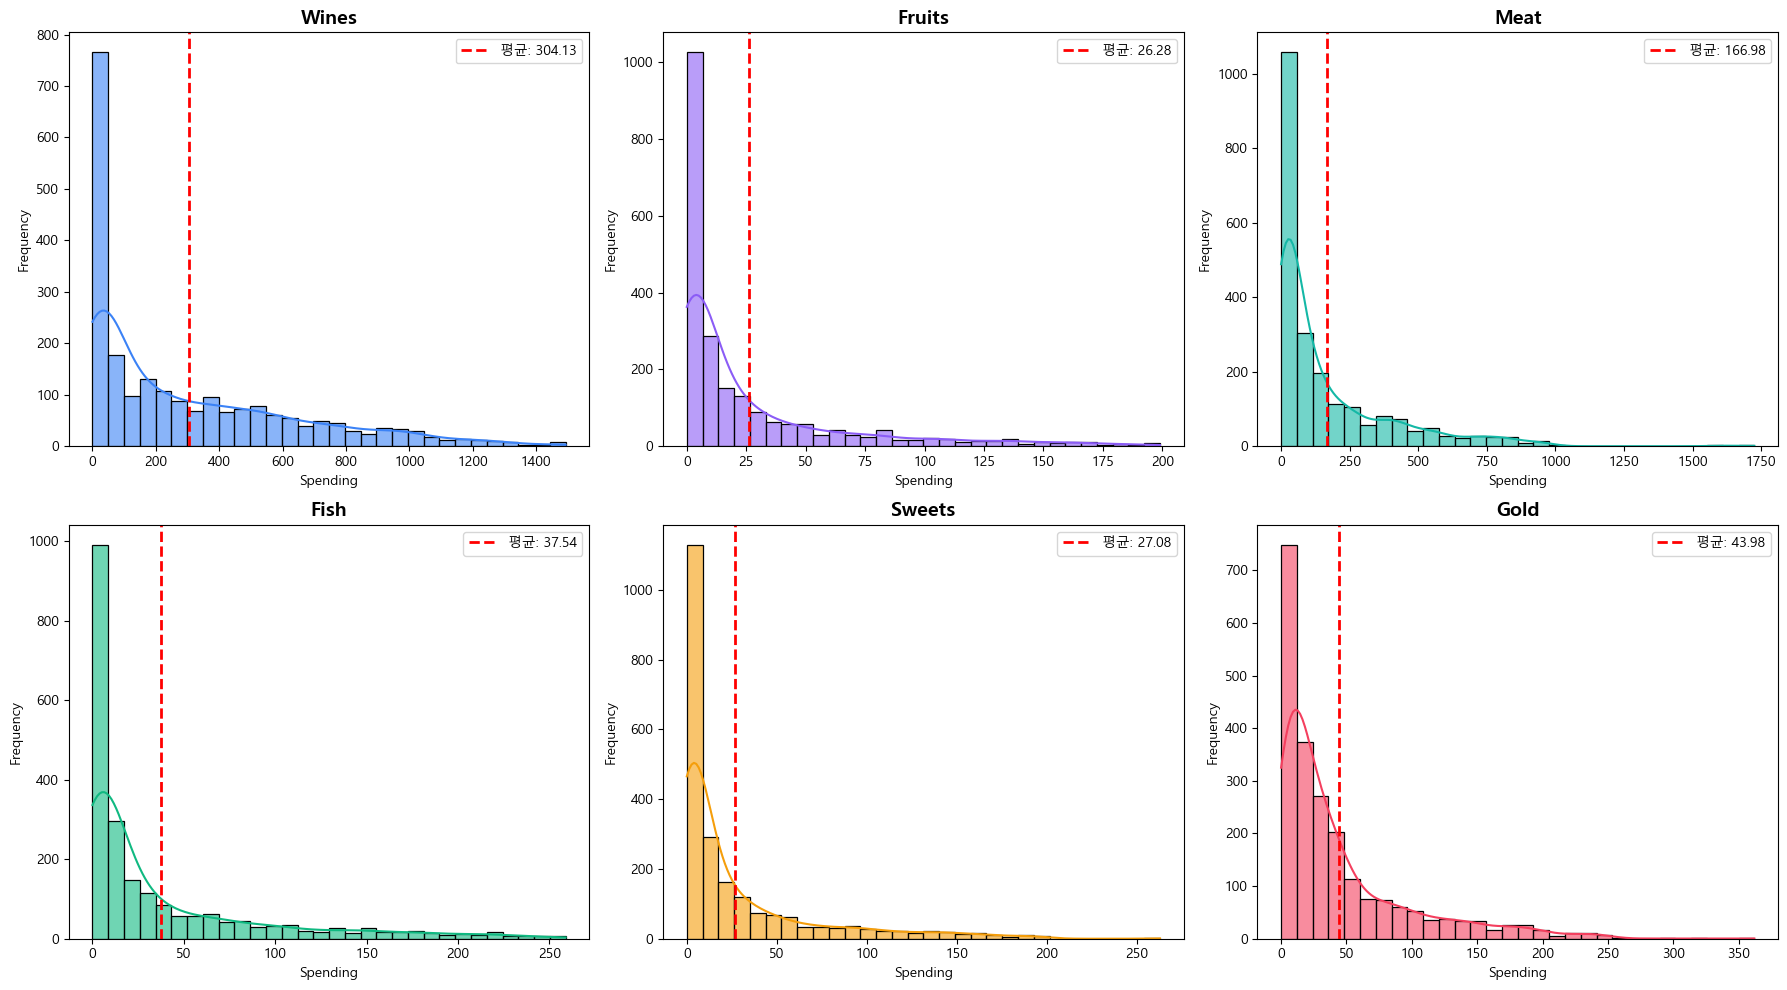

In [66]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (col, name, color) in enumerate(zip(spending_cols, spending_names, hist_colors)):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color=color, alpha=0.6)

    mean_val = df[col].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_val:.2f}')

    axes[i].set_title(f'{name}', fontweight='bold', fontsize=14)
    axes[i].set_xlabel('Spending')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [67]:
# TODO 1-4: 비즈니스 인사이트 정리
# 1.
# 연령: 평균 약 55세, 중앙값 54세로 중장년층이 주력 고객입니다.
# 소득: 평균 약 52000달러 수준이며, 평균이 중앙값보다 약간 높은 우편향(Right-skewed)경향이 있다.
# 소비 특성: 총 소비액의 평균과 중앙값의 차이가 크다.

#2.
# 분포 특성: 6개의 모든 품목에서 왜도가 1이상으로 높게 나왔다. 특히, Fruits, Meat, Sweets는 왜도가 2를 넘으며 매우 강한 우편향을 보인다.
# 바이올린 플롯 결과 High그룹에 비해 Low그룹은 소비액이 0에 가깝게 밀집되어 있어 소득에 따른 구매력 격차가 매우 극명하다.
# 히스토그램을 봤을 때, Wine, Meats는 다른 품목에 비해 압도적인 지출 규모를 자랑한다.

#3.
# 가설1: 와인과 육류의 헤비유저가 캠페인 수락률이 더욱 높을 것이다.
# 가설2: 자녀가 있는 가구는 소득이 높더라도 총 소비액이 낮을 것이다.
# 가설3: 최근 가입 고객일수록 캠페인 반응도가 더 즉각적일 것이다.

---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [77]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10
p = df['Response'].mean()
print(f"전체 캠페인 수락률(p): {p:.4f}")

prob_2 = stats.binom.pmf(2, n_trial, p)
print(f"10명 중 정확히 2명이 수락할 확률: {prob_2:.4f}")

prob_up3 = stats.binom.sf(2, n_trial, p)
print(f"10명 중 3명 이상이 수락할 확률: {prob_up3:.4f}")

전체 캠페인 수락률(p): 0.1494
10명 중 정확히 2명이 수락할 확률: 0.2752
10명 중 3명 이상이 수락할 확률: 0.1782


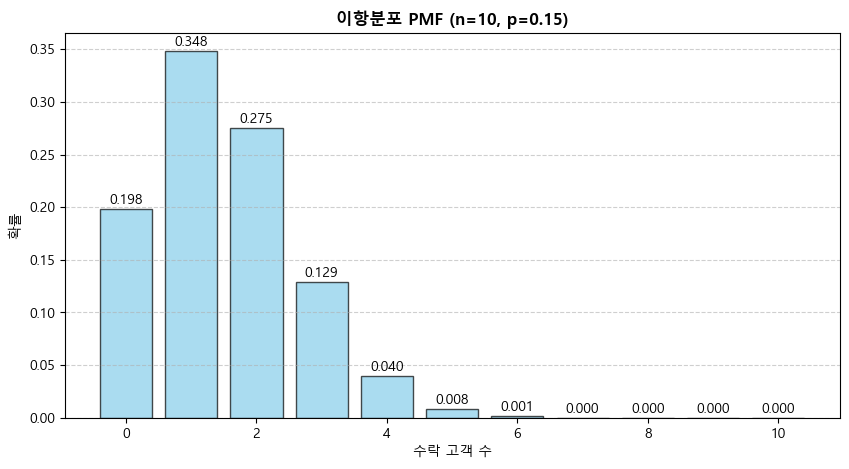

In [86]:
# TODO 2-1(c): 이항분포 PMF 시각화
x = np.arange(0, n_trial+1)
pmf_values = stats.binom.pmf(x, n_trial, p)

plt.figure(figsize=(10,5))
plt.bar(x, pmf_values, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f"이항분포 PMF (n={n_trial}, p={p:.2f})", fontweight='bold')
plt.xlabel('수락 고객 수')
plt.ylabel('확률')

for i, v in enumerate(pmf_values):
    plt.text(i, v + 0.005, f'{v:.3f}', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [93]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100

expected_val = n_campaign * p
print(f"기대 수락자 수: {expected_val:.2f}명")

prob_up15 = stats.binom.sf(14, n_campaign, p)
print(f"15명 이상 수락 확률: {prob_up15:.4f}")

k_min = stats.binom.ppf(0.90, n_campaign, p)
print(f"고객 100명 중 약 90%의 확률로 {k_min:.0f}명 이하가 수락할 것으로 예상됩니다.")

기대 수락자 수: 14.94명
15명 이상 수락 확률: 0.5358
고객 100명 중 약 90%의 확률로 20명 이하가 수락할 것으로 예상됩니다.


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [94]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
lambda_web = web_visits.mean()
print(f"추정된 람다(평균): {lambda_web:.4f}")

variance_web = web_visits.var()
print(f"표본 분산: {variance_web:.4f}")

print(f"차이 (분산/평균 비율): {variance_web / lambda_web:.4f}")

추정된 람다(평균): 5.3189
표본 분산: 5.8898
차이 (분산/평균 비율): 1.1073


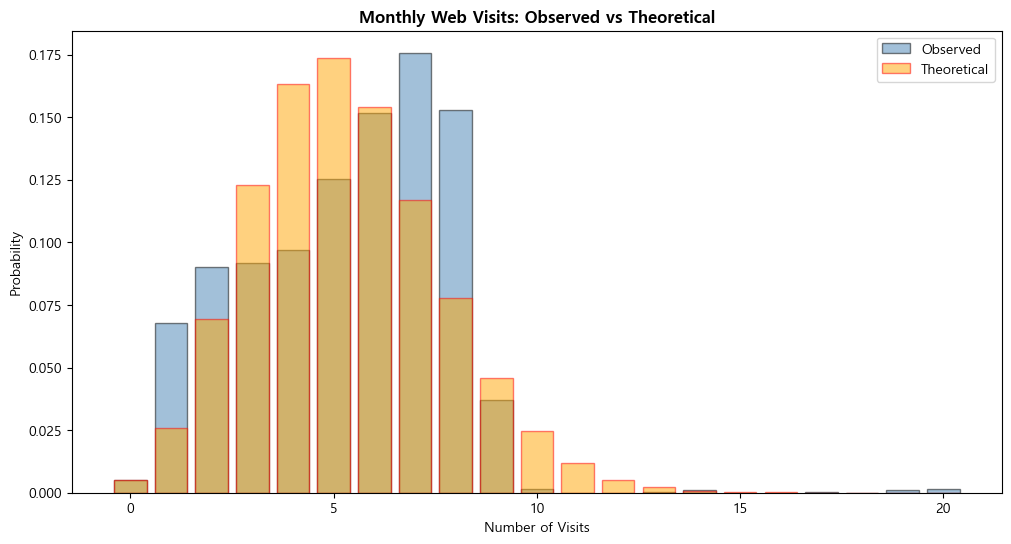

In [102]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
from scipy.stats import poisson
x_range = np.arange(0, web_visits.max() + 1)

# 실측
observed_pmf = web_visits.value_counts(normalize=True).sort_index()
observed_pmf = observed_pmf.reindex(x_range, fill_value=0)

# 이론
theoretical_pmf = poisson.pmf(x_range, lambda_web)

plt.figure(figsize=(12, 6))
plt.bar(x_range, observed_pmf, alpha=0.5, color='steelblue', width=0.8, edgecolor='black', label='Observed')
plt.bar(x_range, theoretical_pmf, alpha=0.5, color='orange', width=0.8, edgecolor='red', label='Theoretical')
plt.title("Monthly Web Visits: Observed vs Theoretical", fontweight='bold')
plt.xlabel('Number of Visits')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [106]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10

prob_heavy = stats.poisson.sf(heavy_threshold - 1, lambda_web)
print(f"월 {heavy_threshold}회 이상 방문할 확률: {prob_heavy * 100:.2f}")

k_capacity = stats.poisson.ppf(0.95, lambda_web)
print(f"서버 용량 계획 (95%): 월 {k_capacity:.0f}회 방문까지 대비 필요")

월 10회 이상 방문할 확률: 4.49
서버 용량 계획 (95%): 월 9회 방문까지 대비 필요


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [110]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교
income_mean = df['Income'].mean()
income_std = df['Income'].std()

print(f"추정된 평균(mu): {income_mean:.2f}")
print(f"추정된 표준편차(sigma): {income_std:.2f}")

#이론
prob_under_30000_theory = stats.norm.cdf(30000, income_mean, income_std)
prob_over_80000_theory = stats.norm.sf(80000, income_mean, income_std)

#실측
prob_under_30000_actual = (df['Income'] < 30000).mean()
prob_over_80000_actual = (df['Income'] > 80000).mean()

print(f"p(Income < 30,000): 이론({prob_under_30000_theory:.4f}) vs 실측({prob_under_30000_actual:.4f})")
print(f"p(Income > 80,000): 이론({prob_over_80000_theory:.4f}) vs 실측({prob_over_80000_actual:.4f})")

income_top10_theory = stats.norm.ppf(0.90, income_mean, income_std)
income_top10_actual = df['Income'].quantile(0.90)

print(f"상위 10% 소득 기준: 이론({income_top10_theory:.4f}) vs 실측({income_top10_actual:.4f})")

추정된 평균(mu): 51952.61
추정된 표준편차(sigma): 21411.47
p(Income < 30,000): 이론(0.1526) vs 실측(0.1655)
p(Income > 80,000): 이론(0.0951) vs 실측(0.0962)
상위 10% 소득 기준: 이론(79392.5129) vs 실측(79747.5000)


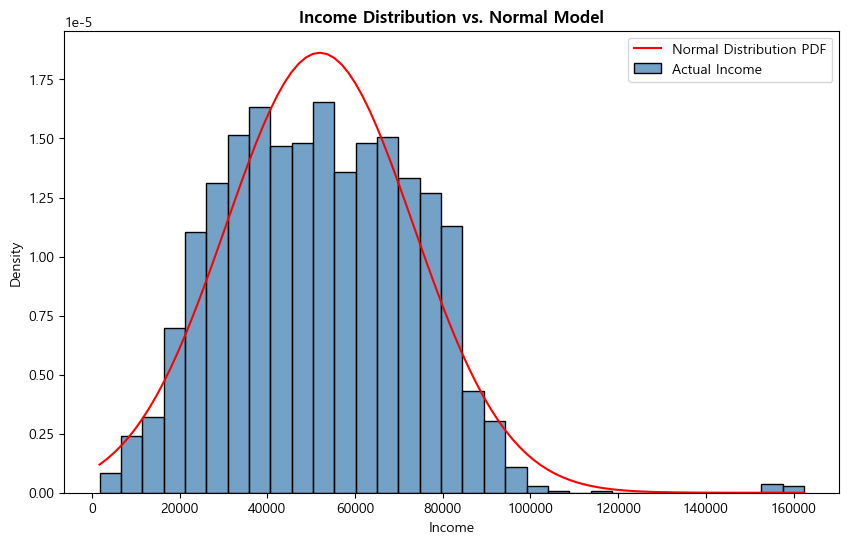

In [113]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기
plt.figure(figsize=(10, 6))

sns.histplot(df['Income'], kde=False, stat='density', color='steelblue', label='Actual Income')

x_range = np.linspace(df['Income'].min(), df['Income'].max(), 100)
pdf_values = stats.norm.pdf(x_range, income_mean, income_std)
plt.plot(x_range, pdf_values, color='red', label='Normal Distribution PDF')

plt.title('Income Distribution vs. Normal Model', fontweight='bold')
plt.xlabel('Income')
plt.ylabel('Density')
plt.legend()
plt.show()

In [116]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선
vip_threshold = stats.norm.ppf(0.95, income_mean, income_std)

discount_threshold = stats.norm.ppf(0.10, income_mean, income_std)

print(f"VIP: {vip_threshold:,.0f}달러 이상")
print(f"할인 대상: {discount_threshold:,.0f}달러 이하")

VIP: 87,171달러 이상
할인 대상: 24,513달러 이하


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [117]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE
spending = df['Total_Spending']
n = len(spending)
mean_val = spending.mean()
se = spending.std() / np.sqrt(n)

confidence_levels = [0.90, 0.95, 0.99]

for cl in confidence_levels:
    ci_low, ci_high = stats.t.interval(cl, n-1, loc=mean_val, scale=se)

    print(f"{cl*100}% CI: [{ci_low:.2f} ~ {ci_high:.2f}] (폭: {ci_high - ci_low:.2f})")

90.0% CI: [585.04 ~ 626.93] (폭: 41.89)
95.0% CI: [581.03 ~ 630.95] (폭: 49.92)
99.0% CI: [573.17 ~ 638.80] (폭: 65.63)


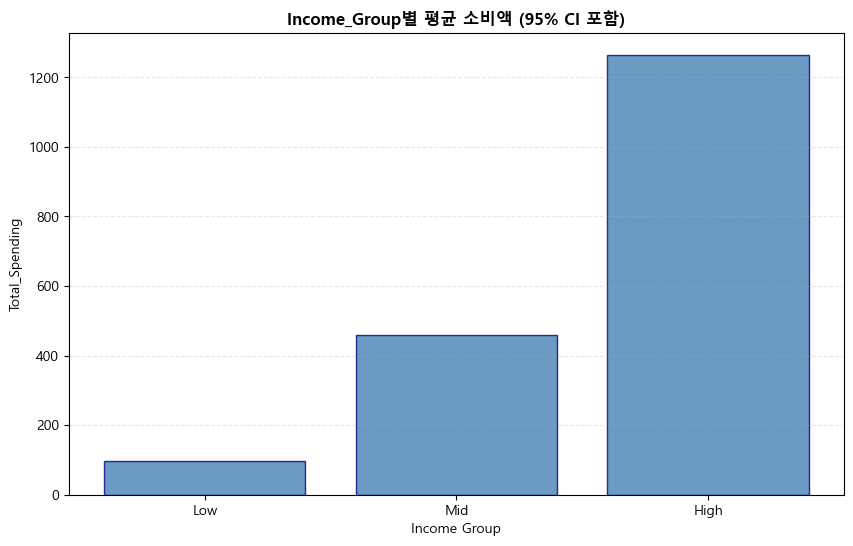

In [125]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프
groups = df['Income_Group'].unique().sort_values()
means=[]
cis=[]

for group in groups:
    data = df[df['Income_Group'] == group]['Total_Spending']
    n_g = len(data)
    m_g = data.mean()
    se_g = data.std() / np.sqrt(n_g)
    
    h = se_g * stats.t.ppf((1 + 0.95) / 2, n_g - 1) # 95% 신뢰구간 오차범위 (t * SE)
    means.append(m_g)
    cis.append(h)

plt.figure(figsize=(10, 6))
plt.bar(groups, means, color='steelblue', edgecolor='navy', alpha=0.8)

plt.title('Income_Group별 평균 소비액 (95% CI 포함)', fontweight='bold')
plt.ylabel('Total_Spending')
plt.xlabel('Income Group')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [ ]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
t_stat, p_val = stats.ttest_ind(no_child, yes_child, equal_var=False)

n1, n2 = len(no_child), len(yes_child)
s1, s2 = no_child.var(), yes_child.var()
pooled_std = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
cohen_d = (no_child.mean() - yes_child.mean()) / pooled_std

print(f"t-통계량: {t_stat:.4f}")
print(f"p-value: {p_val}")

alpha = 0.05
if p_val < alpha:
    print(f"결과 p=value < {alpha} 이므로 귀무가설을 기각한다.")
else:
    print(f"결과 p=value >= {alpha} 이므로 귀무가설을 채택한다.")
print(f"Cohen's d: {abs(cohen_d):.4f}")

d_abs = abs(cohen_d)
if d_abs < 0.5:
    effect_size = "작은"
elif d_abs < 0.8:
    effect_size = "중간"
else:
    effect_size = "큰"
print(f"해석: 효과크기가 {effect_size} 수준이다.")

t-통계량: 24.9889
p-value: 6.321230429385628e-105
결과 p=value < 0.05 이므로 귀무가설을 기각한다.
Cohen's d: 1.3599
해석: 효과크기가 큰 수준이다.


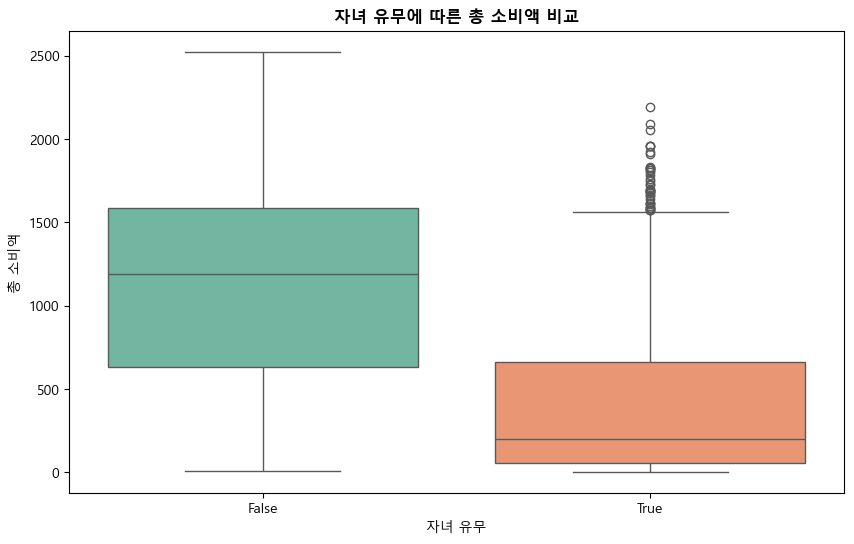

In [132]:
# TODO 3-2(c): 박스플롯 비교 시각화
plt.figure(figsize=(10, 6))

sns.boxplot(x='Has_Children', y='Total_Spending', data=df, palette='Set2')

plt.title("자녀 유무에 따른 총 소비액 비교", fontweight='bold')
plt.xlabel('자녀 유무')
plt.ylabel('총 소비액')

plt.show()

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [135]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
diff = wines - meat

t_stat, p_val = stats.ttest_rel(wines, meat)

cohen_d = diff.mean() / diff.std(ddof=1)

print(f"평균 차이: {diff.mean():.2f}")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-value: {p_val}")

alpha = 0.05
if p_val < alpha:
    print(f"결과: p-value < {alpha}이므로 귀무가설을 기각한다.")
else:
    print(f"결과: p-value >= {alpha}이므로 귀무가설을 채택한다.")

print(f"Cohen's d: {abs(cohen_d):.4f}")

평균 차이: 137.14
t-통계량: 23.0929
p-value: 5.391926544698085e-106
결과: p-value < 0.05이므로 귀무가설을 기각한다.
Cohen's d: 0.4884


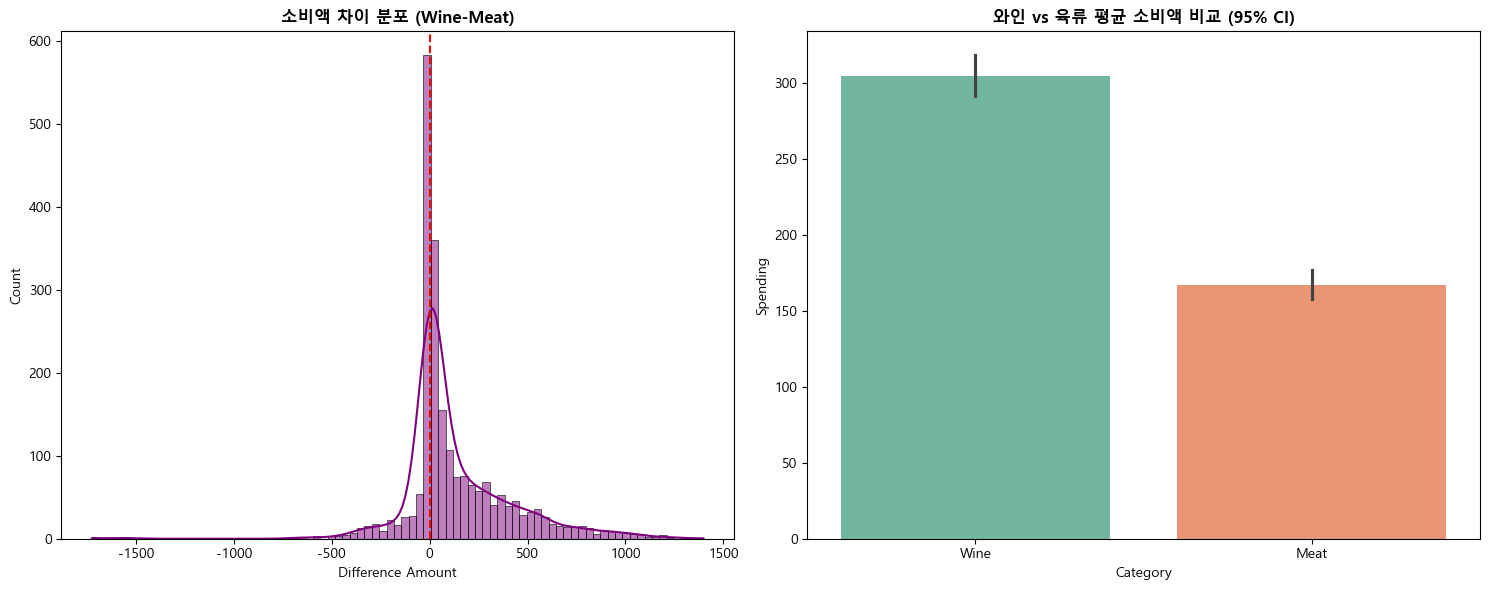

In [142]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(diff, kde=True, ax=axes[0], color='purple')
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_title('소비액 차이 분포 (Wine-Meat)', fontweight='bold')
axes[0].set_xlabel('Difference Amount')

melted_df = pd.melt(df[['MntWines','MntMeatProducts']], var_name='Category', value_name='Spending')
sns.barplot(x='Category', y='Spending', data=melted_df, ax=axes[1], palette='Set2')
axes[1].set_title('와인 vs 육류 평균 소비액 비교 (95% CI)', fontweight='bold')
axes[1].set_xticklabels(['Wine', 'Meat'])

plt.tight_layout()
plt.show()

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [148]:
power_analysis = TTestIndPower()

# TODO 3-4(a): 문제 3-2 기준 검정력 계산
ratio = len(yes_child) / len(no_child)

current_power = power_analysis.solve_power(
    effect_size=abs(cohen_d), 
    nobs1=len(no_child), 
    ratio=ratio, 
    alpha=0.05, 
    alternative='two-sided'
)

print(f"효과 크기(d): {abs(cohen_d):.4f}")
print(f"현재 검정력: {current_power:.4f}")

# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정
target_effect_size = 0.2
target_power = 0.8
alpha = 0.05

required_n = power_analysis.solve_power(
    effect_size=target_effect_size,
    power=target_power,
    alpha=alpha,
    alternative='two-sided'
)

print(f"작은 효과(d=0.2)를 {target_power*100:.0f}% 확률로 탐지하기 위해서")
print(f"필요한 그룹당 최소 표본 크기: {np.ceil(required_n):.0f}명")

효과 크기(d): 0.4884
현재 검정력: 1.0000
작은 효과(d=0.2)를 80% 확률로 탐지하기 위해서
필요한 그룹당 최소 표본 크기: 394명


---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [151]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)
edu_data = [df[df['Education_Group'] == g]['Total_Spending'] for g in edu_groups]

for group_name, data in zip(edu_groups, edu_data):
    shapiro_stat, p_val = stats.shapiro(data)
    n_size = len(data)

    print(f"[{group_name}] (n={n_size})")
    print(f" Shapiro p-value: {p_val}")

    if p_val < 0.05:
        print(f"정규성 기각")
        if n_size >= 30:
            print(f" ->하지만 n >= 30이라 CLT에 의해 ANOVA 가능")
    else:
        print(f"정규성 만족")

# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
levene_stat, p_val_levene = stats.levene(*edu_data)
print(f"p-value: {p_val_levene:.4f}")

if p_val_levene < 0.05:
    print("결과 : 등분산성 위반 ->Welch's ANOVA 사용해야 함.")
    use_welch = True
else:
    print("결과: 등분산성 만족 ->일반 ANOVA 사용한다.")
    use_welch = False

[Undergraduate] (n=255)
 Shapiro p-value: 5.543648052614619e-19
정규성 기각
 ->하지만 n >= 30이라 CLT에 의해 ANOVA 가능
[Graduate] (n=1126)
 Shapiro p-value: 3.561909628976696e-29
정규성 기각
 ->하지만 n >= 30이라 CLT에 의해 ANOVA 가능
[Postgraduate] (n=855)
 Shapiro p-value: 1.7757879312718283e-25
정규성 기각
 ->하지만 n >= 30이라 CLT에 의해 ANOVA 가능
p-value: 0.0000
결과 : 등분산성 위반 ->Welch's ANOVA 사용해야 함.


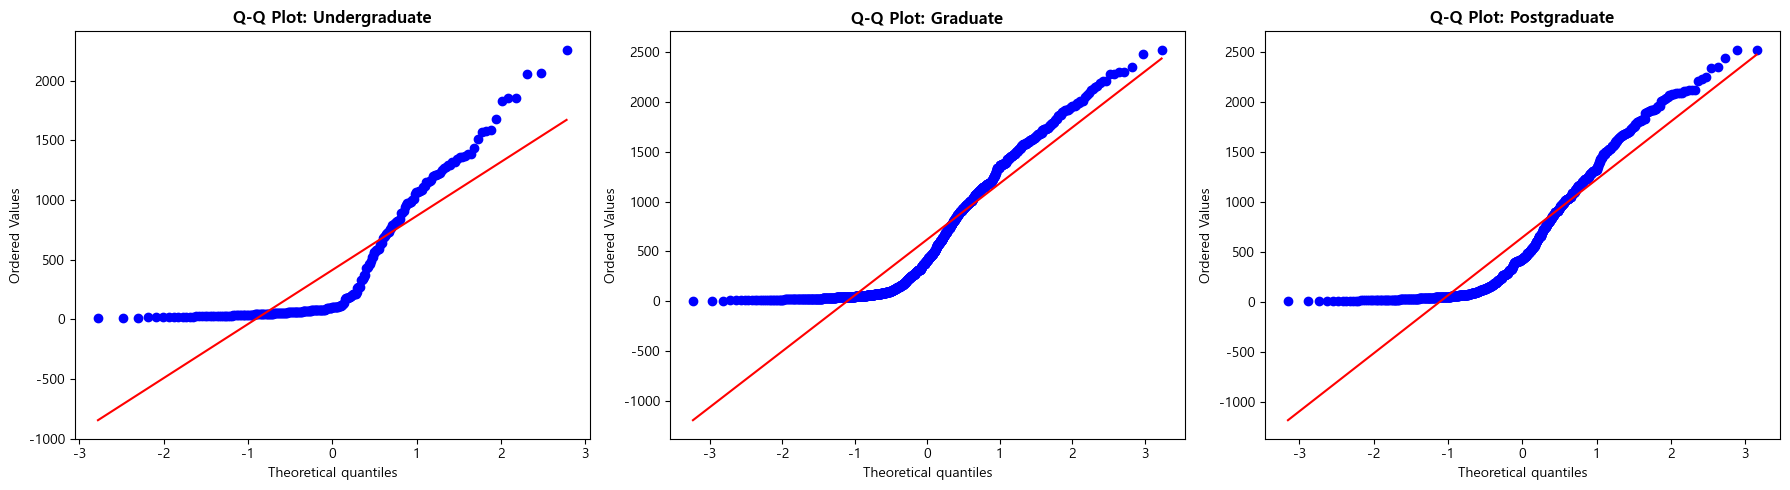

In [152]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (group_name, data) in enumerate(zip(edu_groups, edu_data)):
    stats.probplot(data, dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot: {group_name}', fontweight='bold')
plt.tight_layout()
plt.show()

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [156]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
if use_welch:
    aov = pg.welch_anova(dv='Total_Spending', between='Education_Group', data=df)
    display(aov)
else:
    aov = pg.anova(dv='Total_Spending', between='Education_Group', data=df)
    display(aov)

kw_result = stats.kruskal(*[df[df['Education_Group'] == g]['Total_Spending'] for g in edu_groups])
print(f"\n비모수 검정(Kruskal-Wallis) p-value: {kw_result.pvalue}")

# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)
eta_sq = aov['np2'].values[0]

if not use_welch:
    ss_between = aov['SS'].values[0]
    ss_total = ss_between + aov['SS'].values[1]
    ms_within = aov['MS'].values[1]
    df_between = aov['DF'].values[0]
    omega_sq = (ss_between - (df_between * ms_within)) / (ss_total + ms_within)
    print(f"효과 크기: Eta-sq = {eta_sq:.4f}, Omega-sq = {omega_sq:.4f}")

,Source,ddof1,ddof2,F,p-unc,np2
0,Education_Group,2,751.708152,19.817377,4.098696e-09,0.0137



비모수 검정(Kruskal-Wallis) p-value: 1.1207736037427136e-08


In [159]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g

if use_welch:
    posthoc = pg.pairwise_gameshowell(dv='Total_Spending', between='Education_Group', data=df)
    p_col = 'pval'
else :
    posthoc = pg.pairwise_tukey(dv='Total_Spending', between='Education_Group', data=df)
    p_col = 'p-tukey'

cols_to_show = ['A', 'B', 'mean(A)', 'mean(B)', 'diff', p_col, 'hedges']
print(posthoc[cols_to_show])

              A              B     mean(A)     mean(B)        diff  \
0      Graduate   Postgraduate  620.394316  644.791813  -24.397497   
1      Graduate  Undergraduate  620.394316  412.254902  208.139414   
2  Postgraduate  Undergraduate  644.791813  412.254902  232.536911   

           pval    hedges  
0  6.523632e-01 -0.040121  
1  8.920656e-08  0.355688  
2  9.577128e-09  0.389636  


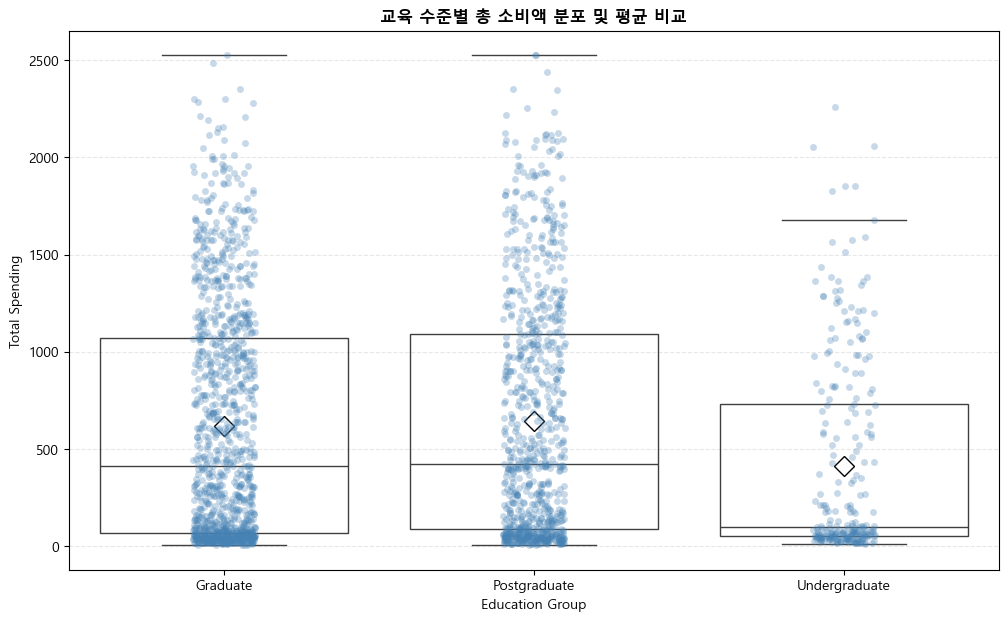

In [166]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드
plt.figure(figsize=(12, 7))

sns.stripplot(x='Education_Group', y='Total_Spending', data=df,
              color='steelblue', alpha=0.3)
sns.boxplot(x='Education_Group', y='Total_Spending', data=df, 
            showmeans=True, meanprops={"marker":"D","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"},
            boxprops={'facecolor':'None'}, whiskerprops={'linewidth':0}, 
            showfliers=False, zorder=2)
plt.title('교육 수준별 총 소비액 분포 및 평균 비교', fontweight='bold')
plt.xlabel('Education Group')
plt.ylabel('Total Spending')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

In [169]:
# 1. 먼저 실제 어떤 그룹들이 있는지 출력해서 확인해봅시다.
print("현재 표의 행(결혼 상태):", crosstab_no_margin.index.tolist())
print("현재 표의 열(반응 여부):", crosstab_no_margin.columns.tolist())

현재 표의 행(결혼 상태): ['Single', 'Together']
현재 표의 열(반응 여부): [False, True]


### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [191]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
from scipy.stats import chi2_contingency
chi2, p_val, dof, expected = chi2_contingency(crosstab_no_margin)

n_total = expected.size
n_below_5 = (expected < 5).sum()
cochran_violation = (n_below_5 / n_total) > 0.20

print(f"카이제곱 통계량: {chi2:.4f}")
print(f"p-value: {p_val}")
print(f"Cochran 규칙 위반 여부 (기대빈도 < 5 비율 {n_below_5/n_total*100:.1f}%): {cochran_violation}")

# TODO 4-3(b): φ (phi) 계산
n = crosstab_no_margin.sum().sum()
phi = np.sqrt(chi2 / n)
print(f"효과 크기 : {phi:.4f}")

# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산

a = crosstab_no_margin.loc['Together', True]
b = crosstab_no_margin.loc['Together', False]
c = crosstab_no_margin.loc['Single', True]
d = crosstab_no_margin.loc['Single', False]

odds_ratio = (a * d) / (b * c)

log_or = np.log(odds_ratio)
se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
ci_low = np.exp(log_or - 1.96 * se_log_or)
ci_high = np.exp(log_or + 1.96 * se_log_or)

print(f"Odds Ratio: {odds_ratio:.4f}")
print(f"95% CI: [{ci_low:.4f}, {ci_high:.4f}]")

카이제곱 통계량: 9.2368
p-value: 0.002372044985880111
Cochran 규칙 위반 여부 (기대빈도 < 5 비율 0.0%): False
효과 크기 : 0.0643
Odds Ratio: 0.7396
95% CI: [0.6105, 0.8959]


In [ ]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵
# 일단은 여기까지.....앞에 밀린 과제들도 하고 하다보니 너무 많아서 토할거같아요...ㅋㅋ큐ㅠㅠㅠ 차근차근 다시 과제 해보는걸로 하겠습니다...

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [ ]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
# TODO 4-4(b): Cohen's w 계산

In [ ]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프

---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [ ]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산
# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)

In [ ]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)

In [ ]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요

### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [ ]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b

# TODO 5-2(a): z-비율검정
# TODO 5-2(b): Cohen's h 효과 크기
# TODO 5-2(c): Wilson 신뢰구간

In [ ]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)

> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [ ]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산
# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)

---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [ ]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [ ]:
# TODO C-2: 비즈니스 제안서 작성

---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛